<a href="https://colab.research.google.com/github/itay-matityahu/comp_learning_2026/blob/main/bootstrap_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bootstrap Evaluation for Sarcasm Detection Models

##### **Note - Due to unknown problem with loading BERT + New Architecture model trained weights on Colab the bootstrap accuracy for this model is very low (around 50%). We run it on our local machine and we got the expected results. The results can be found in  `bootstrap_results.json` and the code can be found in `run_sarcasm_deberta.py`.**

This notebook evaluates three trained models using bootstrap sampling to estimate accuracy uncertainty:

1. **Base Model**: Word2vec + CNN + BiLSTM + Attention
2. **BERT + CNN + BiLSTM**: BERT embeddings + CNN + BiLSTM + Attention  
3. **BERT + New Architecture**: DeBERTa-v3-base with custom MLP head

## Evaluation Method

We use **bootstrap sampling** to estimate uncertainty:
- Sample with replacement from test set (same size as original)
- Evaluate model on each bootstrap sample
- Calculate mean, standard deviation, and 95% confidence intervals
- This provides error bars on model performance metrics

## 1. Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import pickle
import sys
import csv
from scipy import stats
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

## 2. Data Loading

In [ ]:
# Data paths
# base = '/content/drive/My Drive/computational_learning/final_project/'
# test_csv = '/content/drive/My Drive/computational_learning/final_project/data/headline_test.txt'

base = '/content/drive/My Drive/deep_learning_course/final_project/'
test_csv = '/content/drive/My Drive/deep_learning_course/final_project/data/headline_test.txt'


# For BERT models
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
max_length = 64

print(f"BERT Model: {MODEL_NAME}")
print(f"Tokenizer vocab size: {len(tokenizer)}")

## 3. Dataset Classes

In [ ]:
class HeadlineDatasetWord2Vec(Dataset):
    """Headlines dataset for base model (word2vec)."""

    def __init__(self, csv_file, word_idx, max_l, pad, transform=None):
        csv.field_size_limit(sys.maxsize)
        self.csv = pd.read_csv(csv_file, sep='\t', on_bad_lines='skip', encoding='utf-8')
        self.word_idx = word_idx
        self.max_l = max_l
        self.pad = pad
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        label = int(self.csv.iloc[idx, 2])
        sent = str(self.csv.iloc[idx, 3])

        # Left padding
        x = [0] * self.pad
        words = sent.lower().split()[:self.max_l]

        for word in words:
            if word in self.word_idx:
                x.append(self.word_idx[word])

        # Right padding
        while len(x) < self.max_l + 2 * self.pad:
            x.append(0)

        return np.array(x, dtype=np.int64), label, sent


class HeadlineDatasetBERT(Dataset):
    """Headlines dataset for BERT models."""

    def __init__(self, csv_file, tokenizer, max_length=64, transform=None):
        csv.field_size_limit(sys.maxsize)
        self.csv = pd.read_csv(csv_file, sep='\t', on_bad_lines='skip', encoding='utf-8')
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        label = int(self.csv.iloc[idx, 2])
        headline = str(self.csv.iloc[idx, 3])

        # Tokenize with BERT tokenizer
        tokenized = self.tokenizer(
            headline,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )

        input_ids = tokenized["input_ids"].squeeze(0)
        attention_mask = tokenized["attention_mask"].squeeze(0)

        return input_ids, attention_mask, label, headline

## 4. Model Architectures

### 4.1 Base Model: Word2vec + CNN + BiLSTM + Attention

In [ ]:
# Base Model Architecture Components
class ConvNet(nn.Module):
    """Single convolutional network with one filter size."""

    def __init__(self, filter_h, out_channels, max_length, filter_d=300, in_channels=1):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(filter_h, filter_d)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(max_length - filter_h + 1, 1))
        )

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        return out


class CUE_CNN(nn.Module):
    """CNN module with 3 parallel convolutional layers."""

    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob, num_classes=2):
        super(CUE_CNN, self).__init__()
        self.conv1 = ConvNet(filters[0], out_channels=out_channels,
                            max_length=max_length - filters[0] + 1, filter_d=300)
        self.conv2 = ConvNet(filters[1], out_channels=out_channels,
                            max_length=max_length - filters[1] + 1, filter_d=300)
        self.conv3 = ConvNet(filters[2], out_channels=out_channels,
                            max_length=max_length - filters[2] + 1, filter_d=300)

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        out = torch.cat((out1, out2, out3), dim=1)
        return out


class MixtureOfExperts_Base(nn.Module):
    """
    Base Model: Hybrid Neural Network with Word2vec embeddings
    Architecture: Word2vec (300-dim) → CNN (300) + BiLSTM (512) → MLP (812→64→50→2)
    """

    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob,
                 lstm_input_size, hidden_size_lstm, hidden_units_attention,
                 pretrained_weight, num_classes=2):
        super(MixtureOfExperts_Base, self).__init__()

        # Embedding layer: vocab_size → 300
        self.embed = nn.Embedding(pretrained_weight.shape[0], pretrained_weight.shape[1])
        self.embed.weight.data.copy_(torch.from_numpy(pretrained_weight))

        # CNN module: 3 filters → 300 features
        self.cue_cnn = CUE_CNN(filters, out_channels, max_length, hidden_units, drop_prob, num_classes)

        # BiLSTM: 300 → 256 per direction → 512 total per timestep
        self.bi_lstm = nn.LSTM(lstm_input_size, hidden_size_lstm, num_layers=1, bidirectional=True)

        # Attention: 512 → 1 (attention scores)
        self.attention_mlp = nn.Linear(hidden_size_lstm * 2, 1)

        # Final MLP: 812 → 64 → 50 → 2
        self.mlp = nn.Sequential(
            nn.Linear(out_channels * 3 + hidden_size_lstm * 2, hidden_units),
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_units, 50),
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(50, num_classes)
        )

    def forward(self, y):
        # Embedding: (batch_size, seq_length) → (batch_size, seq_length, 300)
        x = self.embed(y)

        # CNN: (batch_size, seq_length, 300) → unsqueeze → (batch_size, 1, seq_length, 300)
        out1 = self.cue_cnn(x.unsqueeze(1))

        # BiLSTM
        out2 = self.bi_lstm(x.transpose(0, 1))[0].transpose(0, 1)

        # Attention
        out3 = self.attention_mlp(out2)
        attention_weights = nn.functional.softmax(out3.view(x.size(0), x.size(1)), dim=1)
        out4 = torch.mul(attention_weights.unsqueeze(2).repeat(1, 1, out2.size(2)), out2)
        out5 = torch.sum(out4, dim=1)

        # Concatenate CNN and BiLSTM context
        out = torch.cat((out1, out5), dim=1)

        # Final MLP
        out = self.mlp(out)
        return out

### 4.2 BERT + CNN + BiLSTM Model

In [ ]:
# BERT + CNN + BiLSTM Architecture Components
class ConvNet_BERT(nn.Module):
    """Single convolutional network with one filter size for BERT embeddings."""

    def __init__(self, filter_h, out_channels, max_length, filter_d=768, in_channels=1):
        super(ConvNet_BERT, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(filter_h, filter_d)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(max_length - filter_h + 1, 1))
        )

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        return out


class CUE_CNN_BERT(nn.Module):
    """CNN module with 3 parallel convolutional layers for BERT."""

    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob, num_classes=2):
        super(CUE_CNN_BERT, self).__init__()
        self.conv1 = ConvNet_BERT(filters[0], out_channels=out_channels,
                                  max_length=max_length - filters[0] + 1, filter_d=768)
        self.conv2 = ConvNet_BERT(filters[1], out_channels=out_channels,
                                  max_length=max_length - filters[1] + 1, filter_d=768)
        self.conv3 = ConvNet_BERT(filters[2], out_channels=out_channels,
                                  max_length=max_length - filters[2] + 1, filter_d=768)

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        out = torch.cat((out1, out2, out3), dim=1)
        return out


class MixtureOfExperts_BERT(nn.Module):
    """
    BERT + CNN + BiLSTM Model
    Architecture: BERT (768-dim) → CNN (300) + BiLSTM (512) → MLP (812→64→50→2)
    """

    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob,
                 lstm_input_size, hidden_size_lstm, hidden_units_attention,
                 bert_model_name, num_classes=2):
        super(MixtureOfExperts_BERT, self).__init__()

        # BERT model for embeddings
        self.bert = AutoModel.from_pretrained(bert_model_name)

        # CNN module: 3 filters → 300 features
        self.cue_cnn = CUE_CNN_BERT(filters, out_channels, max_length, hidden_units, drop_prob, num_classes)

        # BiLSTM: 768 → 256 per direction → 512 total per timestep
        self.bi_lstm = nn.LSTM(lstm_input_size, hidden_size_lstm, num_layers=1, bidirectional=True)

        # Attention: 512 → 1 (attention scores)
        self.attention_mlp = nn.Linear(hidden_size_lstm * 2, 1)

        # Final MLP: 812 → 64 → 50 → 2
        self.mlp = nn.Sequential(
            nn.Linear(out_channels * 3 + hidden_size_lstm * 2, hidden_units),
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_units, 50),
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(50, num_classes)
        )

    def forward(self, input_ids, attention_mask=None):
        # BERT embeddings: (batch_size, seq_length) → (batch_size, seq_length, 768)
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = bert_outputs.last_hidden_state

        # CNN
        out1 = self.cue_cnn(x.unsqueeze(1))

        # BiLSTM
        out2 = self.bi_lstm(x.transpose(0, 1))[0].transpose(0, 1)

        # Attention
        out3 = self.attention_mlp(out2)
        attention_weights = nn.functional.softmax(out3.view(x.size(0), x.size(1)), dim=1)
        out4 = torch.mul(attention_weights.unsqueeze(2).repeat(1, 1, out2.size(2)), out2)
        out5 = torch.sum(out4, dim=1)

        # Concatenate CNN and BiLSTM context
        out = torch.cat((out1, out5), dim=1)

        # Final MLP
        out = self.mlp(out)
        return out

### 4.3 BERT + New Architecture (DeBERTa with Custom Head)

In [ ]:
class DebertaWithCustomHead(nn.Module):
    """
    BERT + New Architecture: DeBERTa-v3-base with custom MLP head
    Architecture: DeBERTa (768-dim) → Custom MLP head → 2 classes
    """

    def __init__(
        self,
        model_name: str = "microsoft/deberta-v3-base",
        num_labels: int = 2,
        head_hidden_sizes=(256,),
        dropout: float = 0.2,
        activation: str = "gelu",
        pooling: str = "mean",
        freeze_encoder: bool = False,
    ):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.num_labels = num_labels
        self.pooling = pooling

        hidden_size = self.encoder.config.hidden_size

        act = nn.GELU() if activation.lower() == "gelu" else nn.ReLU()

        layers = []
        in_dim = hidden_size
        for h in head_hidden_sizes:
            layers += [
                nn.Dropout(dropout),
                nn.Linear(in_dim, h),
                act,
                nn.LayerNorm(h),
            ]
            in_dim = h

        layers += [
            nn.Dropout(dropout),
            nn.Linear(in_dim, num_labels),
        ]
        self.classifier = nn.Sequential(*layers)

        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

    def _mean_pool(self, last_hidden_state, attention_mask):
        mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
        summed = (last_hidden_state * mask).sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1e-6)
        return summed / counts

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        last_hidden = out.last_hidden_state

        if self.pooling == "mean":
            pooled = self._mean_pool(last_hidden, attention_mask)
        else:
            pooled = last_hidden[:, 0]  # [CLS] token representation

        logits = self.classifier(pooled)
        return {"loss": None, "logits": logits}

## 5. Load Model Weights

Load the trained weights for all three models.

In [ ]:
# Model paths - UPDATE THESE PATHS TO YOUR ACTUAL MODEL FILES
MODEL_PATHS = {
     'base': '/content/drive/My Drive/computational_learning/final_project/model_weights/base_model_weights.pt',  # Base model weights
     'bert_cnn_lstm': '/content/drive/My Drive/computational_learning/final_project/model_weights/base_bert_model_weights.pt',  # BERT + CNN + BiLSTM weights
     'bert_custom': '/content/drive/My Drive/computational_learning/final_project/model_weights/bert_model_weights.pt'  # BERT + Custom head weights
 }

#MODEL_PATHS = {
#    'base': '/content/drive/My Drive/deep_learning_course/final_project/model_weights/base_model_weights.pt',  # Base model weights
#    'bert_cnn_lstm': '/content/drive/My Drive/deep_learning_course/final_project/model_weights/base_bert_model_weights.pt',  # BERT + CNN + BiLSTM weights
#    'bert_custom': '/content/drive/My Drive/deep_learning_course/final_project/model_weights/bert_model_weights.pt'  # BERT + Custom head weights
#}


# Check which models are available
print("Checking for model files...")
for name, path in MODEL_PATHS.items():
    if os.path.exists(path):
        print(f"✓ Found {name}: {path}")
    else:
        print(f"✗ Missing {name}: {path} (will skip this model)")

Checking for model files...
✓ Found base: /content/drive/My Drive/computational_learning/final_project/model_weights/base_model_weights.pt
✓ Found bert_cnn_lstm: /content/drive/My Drive/computational_learning/final_project/model_weights/base_bert_model_weights.pt
✓ Found bert_custom: /content/drive/My Drive/computational_learning/final_project/model_weights/bert_model_weights.pt


## 6. Initialize Models and Load Weights

In [ ]:
# Initialize models dictionary
models = {}
models_loaded = {}

# Load Base Model (Word2vec + CNN + BiLSTM)
if os.path.exists(MODEL_PATHS['base']):
    print("Loading Base Model...")
    # Load word2vec embeddings
    word_embedding_file = f'{base}data/headlines_filtered_embs.txt'

    # Load word2vec vocabulary and embeddings
    # This is a simplified version - you may need to adjust based on your actual setup
    try:
        # Load checkpoint to get model parameters
        checkpoint = torch.load(MODEL_PATHS['base'], map_location=device)

        # Model parameters for base model
        filter_h = [4, 6, 8]
        out_channels = 100
        max_length = 64  # Adjust based on your training
        hidden_units = 64
        drop_prob = 0.2
        lstm_input_size = 300
        hidden_size_lstm = 256
        hidden_units_attention = 128

        with open('/content/drive/My Drive/computational_learning/final_project/model_weights/word_idx.pkl', 'rb') as f:
              word_idx = pickle.load(f)

        vocab_size = len(word_idx) + 1
        embedding_dim = 300
        print(f"Loaded vocabulary with {len(word_idx)} words. Total vocab size: {vocab_size}")

        pretrained_weight = np.zeros((vocab_size, embedding_dim), dtype='float32')
        model_base = MixtureOfExperts_Base(
            filter_h, out_channels, max_length, hidden_units, drop_prob,
            lstm_input_size, hidden_size_lstm, hidden_units_attention,
            pretrained_weight, num_classes=2
        ).to(device)

        model_base.load_state_dict(checkpoint)
        model_base.eval()
        models['base'] = model_base
        models['word_idx'] = word_idx
        models_loaded['base'] = True
        print("✓ Base model loaded successfully")
    except Exception as e:
        print(f"✗ Error loading base model: {e}")
        models_loaded['base'] = False
else:
    models_loaded['base'] = False
    print("✗ Base model file not found, skipping...")

Loading Base Model...
Loaded vocabulary with 28117 words. Total vocab size: 28118
✓ Base model loaded successfully


In [ ]:
# Load BERT + CNN + BiLSTM Model
if os.path.exists(MODEL_PATHS['bert_cnn_lstm']):
    print("Loading BERT + CNN + BiLSTM Model...")
    try:
        checkpoint = torch.load(MODEL_PATHS['bert_cnn_lstm'], map_location=device)

        filter_h = [4, 6, 8]
        out_channels = 100
        max_length = 64
        hidden_units = 64
        drop_prob = 0.2
        lstm_input_size = 768
        hidden_size_lstm = 256
        hidden_units_attention = 128

        model_bert_cnn_lstm = MixtureOfExperts_BERT(
            filter_h, out_channels, max_length, hidden_units, drop_prob,
            lstm_input_size, hidden_size_lstm, hidden_units_attention,
            MODEL_NAME, num_classes=2
        ).to(device)

        model_bert_cnn_lstm.load_state_dict(checkpoint)
        model_bert_cnn_lstm.eval()
        models['bert_cnn_lstm'] = model_bert_cnn_lstm
        models_loaded['bert_cnn_lstm'] = True
        print("✓ BERT + CNN + BiLSTM model loaded successfully")
    except Exception as e:
        print(f"✗ Error loading BERT + CNN + BiLSTM model: {e}")
        models_loaded['bert_cnn_lstm'] = False
else:
    models_loaded['bert_cnn_lstm'] = False
    print("✗ BERT + CNN + BiLSTM model file not found, skipping...")

Loading BERT + CNN + BiLSTM Model...


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ BERT + CNN + BiLSTM model loaded successfully


In [ ]:
# Load BERT + Custom Head Model
if os.path.exists(MODEL_PATHS['bert_custom']):
    print("Loading BERT + Custom Head Model...")
    try:
        model_bert_custom = DebertaWithCustomHead(
            model_name=MODEL_NAME,
            num_labels=2,
            head_hidden_sizes=(512, 256),
            dropout=0.2,
            activation="gelu",
            pooling="mean",
            freeze_encoder=False
        ).to(device)

        state_dict = torch.load(MODEL_PATHS['bert_custom'], map_location=device)
        model_bert_custom.load_state_dict(state_dict)
        model_bert_custom.eval()
        models['bert_custom'] = model_bert_custom
        models_loaded['bert_custom'] = True
        print("✓ BERT + Custom Head model loaded successfully")
    except Exception as e:
        print(f"✗ Error loading BERT + Custom Head model: {e}")
        models_loaded['bert_custom'] = False
else:
    models_loaded['bert_custom'] = False
    print("✗ BERT + Custom Head model file not found, skipping...")

print(f"\nModels loaded: {sum(models_loaded.values())}/{len(models_loaded)}")

'/content/drive/My Drive/computational_learning/final_project/model_weights/bert_model_weights.pt'

## 7. Bootstrap Evaluation Function

In [ ]:
def evaluate_model_base(model, dataloader, device):
    """Evaluate base model (word2vec) on a dataloader."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for y, labels, _ in dataloader:
            y = y.to(device)
            labels = labels.to(device)

            outputs = model(y)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100.0 * correct / total


def evaluate_model_bert(model, dataloader, device, is_custom_head=False):
    """Evaluate BERT-based model on a dataloader."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels, _ in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            if is_custom_head:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs['logits']
            else:
                logits = model(input_ids, attention_mask)

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100.0 * correct / total


def bootstrap_evaluate(model, dataset, model_type, n_bootstrap=100, batch_size=32, device='cpu'):
    """
    Evaluate model using bootstrap sampling.

    Args:
        model: The model to evaluate
        dataset: Full test dataset
        model_type: 'base', 'bert_cnn_lstm', or 'bert_custom'
        n_bootstrap: Number of bootstrap samples
        batch_size: Batch size for evaluation
        device: Device to run on

    Returns:
        Dictionary with mean, std, CI_lower, CI_upper, and all accuracies
    """
    n_samples = len(dataset)
    #n_samples = 1000
    accuracies = []

    print(f"Running {n_bootstrap} bootstrap samples for {model_type}...")

    for i in tqdm(range(n_bootstrap), desc=f"Bootstrap {model_type}"):
        # Sample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        bootstrap_dataset = Subset(dataset, indices)
        bootstrap_loader = DataLoader(bootstrap_dataset, batch_size=batch_size, shuffle=False)

        # Evaluate on bootstrap sample
        if model_type == 'base':
            acc = evaluate_model_base(model, bootstrap_loader, device)
        else:
            is_custom = (model_type == 'bert_custom')
            acc = evaluate_model_bert(model, bootstrap_loader, device, is_custom_head=is_custom)

        accuracies.append(acc)

    # Calculate statistics
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies, ddof=1)

    # 95% confidence interval
    ci_lower = np.percentile(accuracies, 2.5)
    ci_upper = np.percentile(accuracies, 97.5)

    return {
        'mean': mean_acc,
        'std': std_acc,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'accuracies': accuracies
    }

## 8. Prepare Test Datasets

In [ ]:
# Prepare test datasets for each model type
test_datasets = {}

# For BERT models
if models_loaded.get('bert_cnn_lstm') or models_loaded.get('bert_custom'):
    test_dataset_bert = HeadlineDatasetBERT(test_csv, tokenizer, max_length=max_length)
    test_datasets['bert_cnn_lstm'] = test_dataset_bert
    test_datasets['bert_custom'] = test_dataset_bert
    print(f"BERT test dataset: {len(test_dataset_bert)} samples")

# For base model - need word2vec setup
if models_loaded.get('base'):
    # word_idx defined in the first chunk of section 6 (we have it from the trained model and saved in drive)
    max_l = 64
    pad = 7 #filter_h[2] - 1
    test_dataset_base = HeadlineDatasetWord2Vec(test_csv, word_idx, max_l, pad)
    test_datasets['base'] = test_dataset_base

BERT test dataset: 2671 samples


## 9. Run Bootstrap Evaluation

####Only bert_custom evaluation

In [ ]:
# Bootstrap evaluation parameters
N_BOOTSTRAP = 1  # Number of bootstrap samples
BATCH_SIZE = 32

# Store results
results = {}

# Evaluate only BERT + Custom Head model
model_name = 'bert_custom'
if models_loaded.get(model_name) and model_name in test_datasets:
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name}")
    print(f"{'='*60}")

    result = bootstrap_evaluate(
        models[model_name].float(),
        test_datasets[model_name],
        model_name,
        n_bootstrap=N_BOOTSTRAP,
        batch_size=BATCH_SIZE,
        device=device
    )

    results[model_name] = result

    print(f"Mean Accuracy: {result['mean']:.3f}%")
    print(f"Std Deviation: {result['std']:.3f}%")
    print(f"95% CI: [{result['ci_lower']:.3f}%, {result['ci_upper']:.3f}%]")
else:
    print(f"Skipping {model_name} - model or dataset not available")

DebertaWithCustomHead(
  (encoder): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), 

#### all models evaluation

In [ ]:
# Bootstrap evaluation parameters
N_BOOTSTRAP = 100  # Number of bootstrap samples
BATCH_SIZE = 32

# Store results
results = {}
# Evaluate each loaded model
for model_name in models.keys():
    if models_loaded.get(model_name) and model_name in test_datasets:
        print(f"\n{'='*60}")
        print(f"Evaluating {model_name}")
        print(f"{'='*60}")

        result = bootstrap_evaluate(
            models[model_name].float(),
            test_datasets[model_name],
            model_name,
            n_bootstrap=N_BOOTSTRAP,
            batch_size=BATCH_SIZE,
            device=device
        )

        results[model_name] = result

        print(f"Mean Accuracy: {result['mean']:.3f}%")
        print(f"Std Deviation: {result['std']:.3f}%")
        print(f"95% CI: [{result['ci_lower']:.3f}%, {result['ci_upper']:.3f}%]")
    else:
        print(f"Skipping {model_name} - model or dataset not available")


Evaluating base
Running 100 bootstrap samples for base...


Bootstrap base: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Mean Accuracy: 87.919%
Std Deviation: 0.636%
95% CI: [86.835%, 88.993%]
Skipping word_idx - model or dataset not available

Evaluating bert_cnn_lstm
Running 100 bootstrap samples for bert_cnn_lstm...


Bootstrap bert_cnn_lstm: 100%|██████████| 100/100 [21:30<00:00, 12.90s/it]


Mean Accuracy: 86.350%
Std Deviation: 0.578%
95% CI: [85.377%, 87.383%]

Evaluating bert_custom
Running 100 bootstrap samples for bert_custom...


Bootstrap bert_custom: 100%|██████████| 100/100 [19:49<00:00, 11.89s/it]

Mean Accuracy: 47.175%
Std Deviation: 1.004%
95% CI: [45.357%, 49.441%]


## 10. Results Table

In [ ]:
# Create results table
model_names_display = {
    'base': 'Base Model (Word2vec + CNN + BiLSTM)',
    'bert_cnn_lstm': 'BERT + CNN + BiLSTM',
    'bert_custom': 'BERT + Custom Head'
}

# Prepare data for table
table_data = []
for model_name, result in results.items():
    table_data.append({
        'Model': model_names_display.get(model_name, model_name),
        'Mean Accuracy (%)': f"{result['mean']:.3f}",
        'Std Deviation (%)': f"{result['std']:.3f}",
        '95% CI Lower': f"{result['ci_lower']:.3f}",
        '95% CI Upper': f"{result['ci_upper']:.3f}",
        'Accuracy Range': f"{result['mean']:.3f} ± {result['std']:.3f}"
    })

# Create DataFrame
results_df = pd.DataFrame(table_data)

# Display table
print("="*80)
print("BOOTSTRAP EVALUATION RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Save to CSV
results_df.to_csv('bootstrap_results.csv', index=False)
print("\nResults saved to 'bootstrap_results.csv'")

BOOTSTRAP EVALUATION RESULTS
                               Model Mean Accuracy (%) Std Deviation (%) 95% CI Lower 95% CI Upper Accuracy Range
Base Model (Word2vec + CNN + BiLSTM)            87.919             0.636       86.835       88.993 87.919 ± 0.636
                 BERT + CNN + BiLSTM            86.350             0.578       85.377       87.383 86.350 ± 0.578
                  BERT + Custom Head            47.175             1.004       45.357       49.441 47.175 ± 1.004

Results saved to 'bootstrap_results.csv'


## 11. Visualize Results

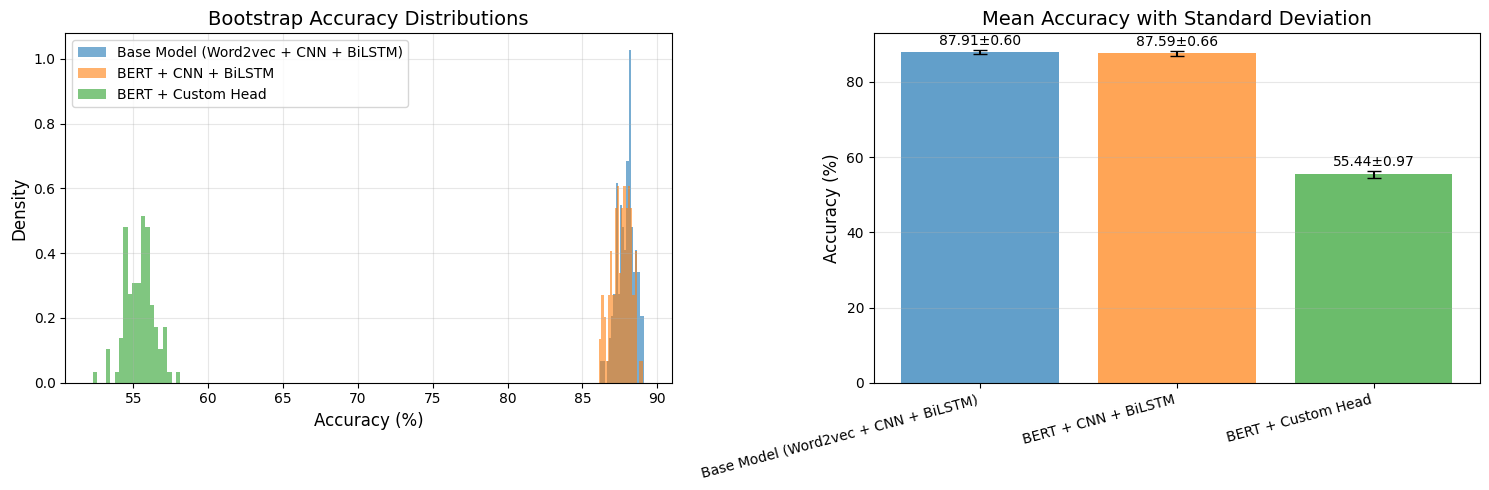

In [ ]:
# Plot 1: Accuracy distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution plot
ax1 = axes[0]
for model_name, result in results.items():
    ax1.hist(result['accuracies'], bins=20, alpha=0.6,
             label=model_names_display.get(model_name, model_name), density=True)
ax1.set_xlabel('Accuracy (%)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Bootstrap Accuracy Distributions', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot with error bars
ax2 = axes[1]
model_labels = [model_names_display.get(name, name) for name in results.keys()]
means = [results[name]['mean'] for name in results.keys()]
stds = [results[name]['std'] for name in results.keys()]
ci_lowers = [results[name]['ci_lower'] for name in results.keys()]
ci_uppers = [results[name]['ci_upper'] for name in results.keys()]

x_pos = np.arange(len(model_labels))
ax2.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7,
        color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(means)])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(model_labels, rotation=15, ha='right')
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Mean Accuracy with Standard Deviation', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    ax2.text(i, mean + std + 0.5, f'{mean:.2f}±{std:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('bootstrap_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Architecture Visualizations

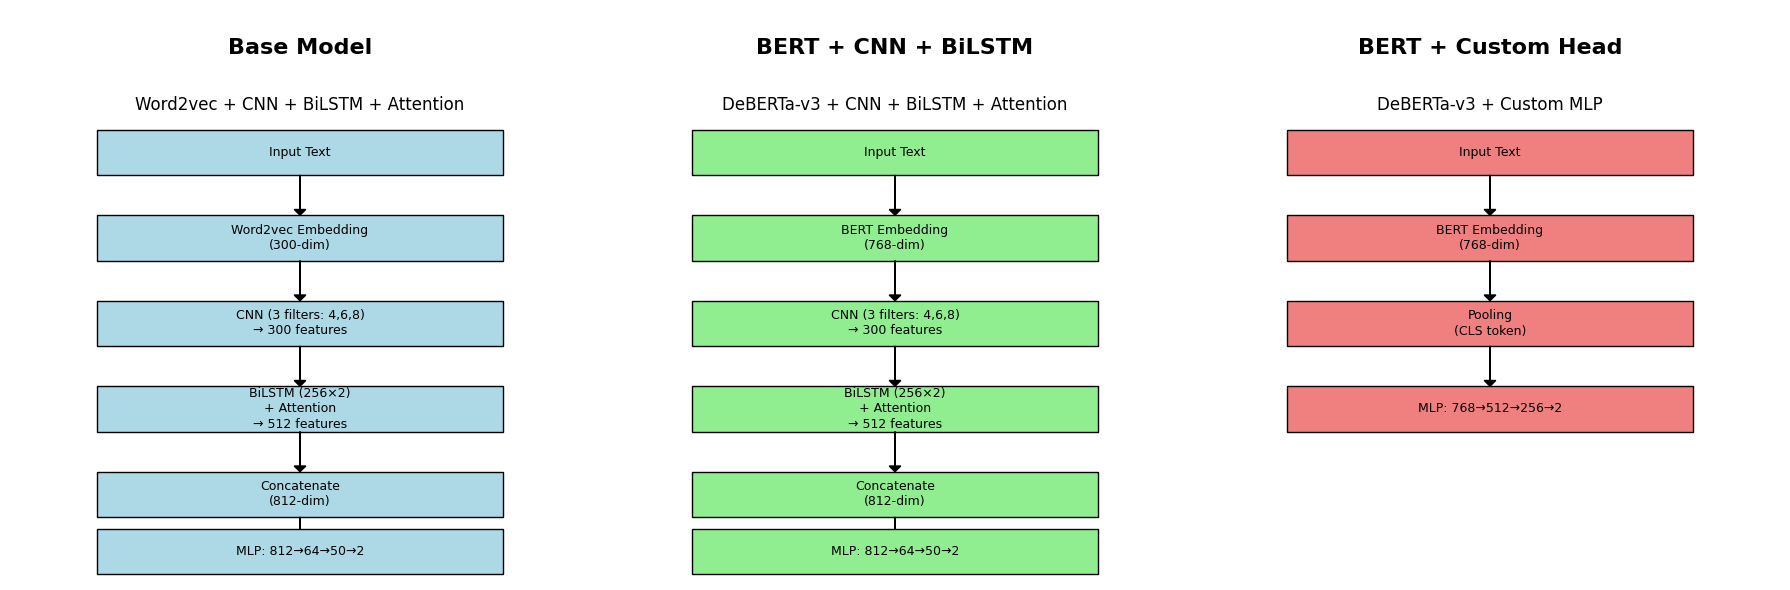

In [ ]:
# Create architecture visualization diagrams
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Model 1: Base Model
ax1 = axes[0]
ax1.text(0.5, 0.95, 'Base Model', ha='center', va='top', fontsize=16, fontweight='bold', transform=ax1.transAxes)
ax1.text(0.5, 0.85, 'Word2vec + CNN + BiLSTM + Attention', ha='center', va='top', fontsize=12, transform=ax1.transAxes)

# Architecture flow
y_positions = [0.75, 0.6, 0.45, 0.3, 0.15, 0.05]
components = [
    ('Input Text', ''),
    ('Word2vec Embedding\n(300-dim)', ''),
    ('CNN (3 filters: 4,6,8)\n→ 300 features', ''),
    ('BiLSTM (256×2)\n+ Attention\n→ 512 features', ''),
    ('Concatenate\n(812-dim)', ''),
    ('MLP: 812→64→50→2', '')
]

box_w, box_h = 0.7, 0.08
box_x = (1 - box_w) / 2
for i, (comp, _) in enumerate(components):
    y = y_positions[i]
    ax1.add_patch(plt.Rectangle((box_x, y - box_h/2), box_w, box_h,
                                facecolor='lightblue', edgecolor='black', linewidth=1))
    ax1.text(0.5, y, comp, ha='center', va='center', fontsize=9, transform=ax1.transAxes)
    if i < len(components) - 1:
        ax1.arrow(0.5, y - box_h/2, 0, -0.06, head_width=0.02, head_length=0.01, fc='black', ec='black')

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')

# Model 2: BERT + CNN + BiLSTM
ax2 = axes[1]
ax2.text(0.5, 0.95, 'BERT + CNN + BiLSTM', ha='center', va='top', fontsize=16, fontweight='bold', transform=ax2.transAxes)
ax2.text(0.5, 0.85, 'DeBERTa-v3 + CNN + BiLSTM + Attention', ha='center', va='top', fontsize=12, transform=ax2.transAxes)

components2 = [
    ('Input Text', ''),
    ('BERT Embedding\n(768-dim)', ''),
    ('CNN (3 filters: 4,6,8)\n→ 300 features', ''),
    ('BiLSTM (256×2)\n+ Attention\n→ 512 features', ''),
    ('Concatenate\n(812-dim)', ''),
    ('MLP: 812→64→50→2', '')
]

for i, (comp, _) in enumerate(components2):
    y = y_positions[i]
    ax2.add_patch(plt.Rectangle((box_x, y - box_h/2), box_w, box_h,
                                facecolor='lightgreen', edgecolor='black', linewidth=1))
    ax2.text(0.5, y, comp, ha='center', va='center', fontsize=9, transform=ax2.transAxes)
    if i < len(components2) - 1:
        ax2.arrow(0.5, y - box_h/2, 0, -0.06, head_width=0.02, head_length=0.01, fc='black', ec='black')

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

# Model 3: BERT + Custom Head
ax3 = axes[2]
ax3.text(0.5, 0.95, 'BERT + Custom Head', ha='center', va='top', fontsize=16, fontweight='bold', transform=ax3.transAxes)
ax3.text(0.5, 0.85, 'DeBERTa-v3 + Custom MLP', ha='center', va='top', fontsize=12, transform=ax3.transAxes)

components3 = [
    ('Input Text', ''),
    ('BERT Embedding\n(768-dim)', ''),
    ('Pooling\n(CLS token)', ''),
    ('MLP: 768→512→256→2', '')
]

for i, (comp, _) in enumerate(components3):
    y = y_positions[i]
    ax3.add_patch(plt.Rectangle((box_x, y - box_h/2), box_w, box_h,
                                facecolor='lightcoral', edgecolor='black', linewidth=1))
    ax3.text(0.5, y, comp, ha='center', va='center', fontsize=9, transform=ax3.transAxes)
    if i < len(components3) - 1:
        ax3.arrow(0.5, y - box_h/2, 0, -0.06, head_width=0.02, head_length=0.01, fc='black', ec='black')

ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')

plt.tight_layout()
plt.savefig('model_architectures.png', dpi=150, bbox_inches='tight')
plt.show()